In [82]:
import pickle
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
from scipy import optimize
from matplotlib import path
import h5py

with open("higgs_100000_pt_250_500.pkl", 'rb') as file:
    higgs_data = pickle.load(file)
    
with open("qcd_100000_pt_250_500.pkl", 'rb') as file:
    qcd_data = pickle.load(file)

pex_low_g = h5py.File("data_lowLumi_pt_250_500.h5", 'r')['data']
pex_high_g = h5py.File("data_highLumi_pt_250_500.h5", 'r')['data']

pex_low = pd.DataFrame(pex_low_g['block0_values'], columns=[l.decode('utf-8') for l in pex_low_g['block0_items']])
pex_high = pd.DataFrame(pex_high_g['block0_values'], columns=[l.decode('utf-8') for l in pex_high_g['block0_items']])

# Lab 7

## Part 1

After normalizing to the expected quantities of 20,000 QCD jets and 100 Higgs jets, the expected mass distribution for each is shown below.

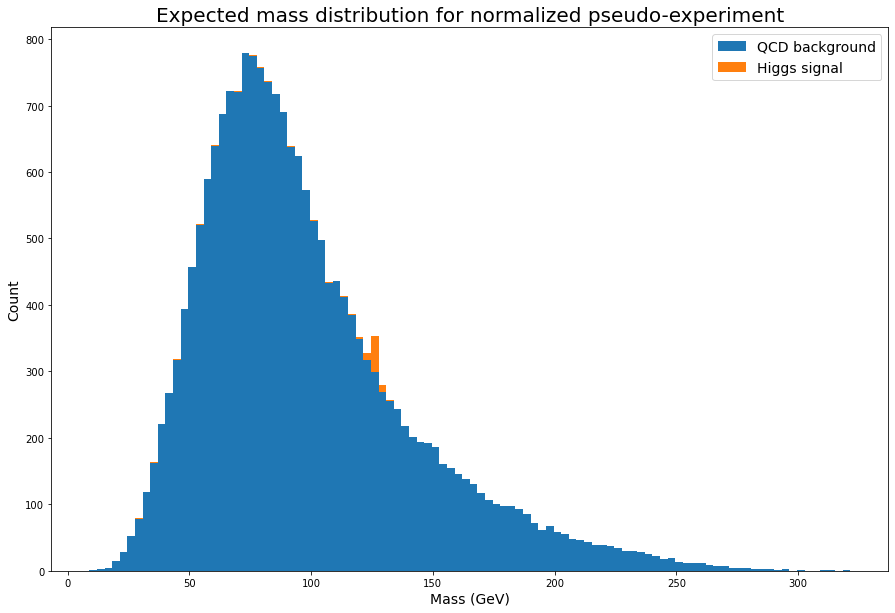

In [129]:
higgs_weight = 100 / 100000
qcd_weight = 20000 / 100000

fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.hist(
    [qcd_data['mass'], higgs_data['mass']],
    weights=[np.repeat(qcd_weight, 100000), np.repeat(higgs_weight, 100000)],
    label=["QCD background", "Higgs signal"],
    bins=100,
    stacked=True
)
ax.set_xlabel("Mass (GeV)", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_title("Expected mass distribution for normalized pseudo-experiment", fontsize=20)
ax.legend(fontsize=14);

In the null hypothesis theory containing only QCD jets we expect to see 20,000 total events, while in the predicted theory containing the Higgs we expect to see 20,100 events. Assuming Poisson statistics, the probability of seeing 20,100 events anyway in the background theory is 0.238, corresponding to a significance of 0.711 sigma. This agrees well with the approximation $N_{Higgs}/\sqrt{N_{QCD}} = 0.707$. The origin of this approximation is that by the CLT, for large values of $\mu$, the Poisson distribution approaches a normal distribution with mean $\mu$ and standard deviation $\sqrt{\mu}$, in which case the significance of an observation $x$ is just $(x - \mu)/\sqrt{\mu}$. Since the Poisson distribution with $\mu = 20000$ is quite Gaussian, we would indeed expect the approximation to work well here. However, once we apply cuts to reduce $N_{QCD}$ this approximation will become rapidly less accurate, so we will not use it from here out.

In [3]:
# exact significance
prob = stats.poisson.sf(20100, mu=20000)
sigma = stats.norm.isf(prob)
print(f"{prob:.3} \t {sigma:.3} sigma")

0.238 	 0.711 sigma


In [4]:
# Gaussian approximation
print(f"{100/np.sqrt(20000):.3} sigma")

0.707 sigma


## Part 2

Since we will be trying to optimize the values for many different cuts on our data, it will be useful to first introduce some helper functions. In the following code, `cut` is assumed to be a function which takes a dataframe (either `qcd_data` or `higgs_data`) and an array of parameters and returns a boolean mask on the rows of the dataframe describing which events are to be included. `significance(cut, par)` is then the expected significance granted by using the filter `cut` with parameter array `par`. (Ignore the argument `incl` for now, we will address it later.) `loss(cut)` returns a function which takes a parameter array and returns the _negative_ expected significance; minimizing this function corresponds to finding the optimal parameters for `cut`. Once we have found the optimal parameters, `print_performance` then simply prints the expected significance and inclusion rates.

In [5]:
# expected significance in sigma granted by a given cut
def significance(cut, par, incl=0):
    higgs_count = np.sum(cut(higgs_data, par)) * higgs_weight
    if higgs_count < incl: return 0
    qcd_count = np.sum(cut(qcd_data, par)) * qcd_weight
    if qcd_count == 0: return 0 # avoid divide by 0
    return stats.norm.isf(stats.poisson.sf(qcd_count + higgs_count, mu=qcd_count))

# 
def loss(cut, incl=0):
    return lambda par: -significance(cut, par, incl)

def print_performance(cut, par):
    print(f"Significance: {significance(cut, par):.3} sigma")
    print("QCD Inclusion: {:.3}% \t Higgs Inclusion: {:.3}%\n".format(
        np.sum(cut(qcd_data, par)) / 1000,
        np.sum(cut(higgs_data, par)) / 1000
    ))

The first filter we will try is a straight-forward single feature cut on mass. We define a cut function `mass_cut` as described above which takes two parameters, the lower and upper bounds on mass.

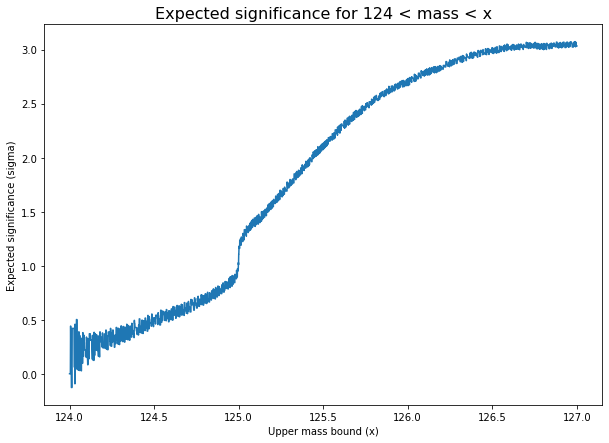

In [6]:
def mass_cut(data, par):
    [lower, upper] = par
    return (data['mass'] > lower) & (data['mass'] < upper)

xx = np.linspace(124, 127, 5000)
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(xx, [significance(mass_cut, [124, x]) for x in xx])
ax.set_xlabel("Upper mass bound (x)")
ax.set_ylabel("Expected significance (sigma)")
ax.set_title("Expected significance for 124 < mass < x", fontsize=16);

Above, we have graphed the expected significance of this cut as a function of the upper bound, assuming a fixed lower bound of 124 GeV, and we can see that its derivative is extremely poorly behaved. This means that gradient-based optimization will not be effective. Instead, we use SciPy's differential evolution algorithm, which is stochastic and global.

In [7]:
res = optimize.differential_evolution(loss(mass_cut), [(0,200), (0,200)])
[mlower, mupper] = res.x
print(f"{mlower:.5} < mass < {mupper:.5}")
print_performance(mass_cut, res.x)

124.74 < mass < 126.56
Significance: 3.2 sigma
QCD Inclusion: 0.86% 	 Higgs Inclusion: 43.0%



The optimal cut provided by the minimizer is to take the mass range between 124.85 GeV and 126.72 GeV, which contains 44% of Higgs events and only 0.87% of QCD events, for an expected significance of 3.2 sigma.

## Section 3

Below, we have plotted stacked histograms of the expected distribution of each of the remaining features, both before and after applying the optimal mass cut found above. Because QCD events dominate the Higgs signal in the pre-cut data (20,000 to 100), we have amplified the Higgs signal by a factor of 20 in that case for clarity.

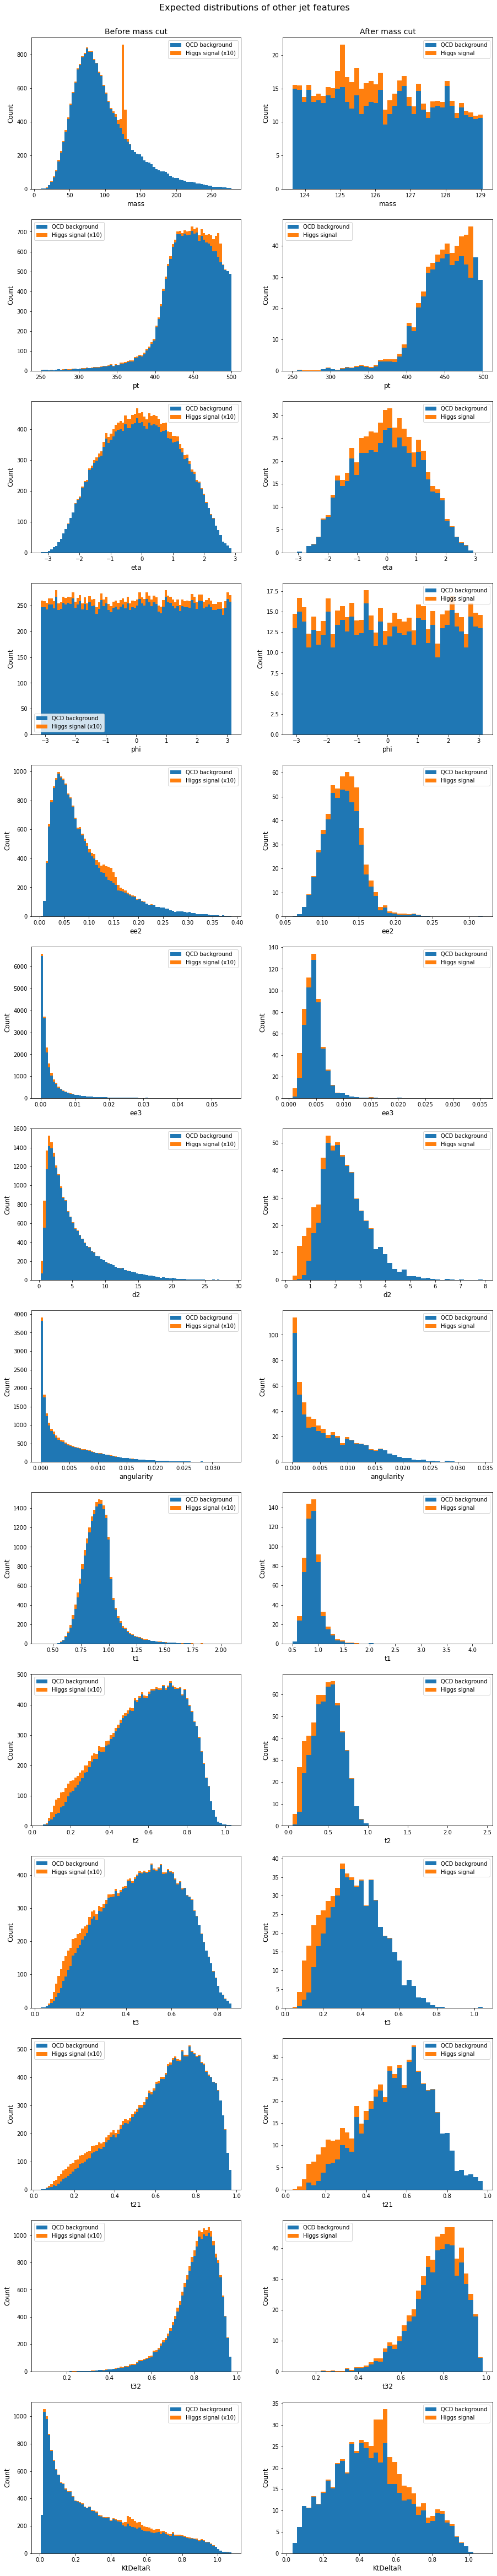

In [148]:
qcd_data_mcut = qcd_data[(qcd_data['mass'] > mlower) & (qcd_data['mass'] < mupper)]
higgs_data_mcut = higgs_data[(higgs_data['mass'] > mlower) & (higgs_data['mass'] < mupper)]

features = ['mass', 'pt', 'eta', 'phi', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR']

fig, ax_grid = plt.subplots(len(features), 2, figsize=(15, 6*len(features)))

fig.suptitle("Expected distributions of other jet features", y=0.89, fontsize=16)
ax_grid[0,0].set_title("Before mass cut", fontsize=14)
ax_grid[0,1].set_title("After mass cut", fontsize=14)

for feature, axs in zip(features, ax_grid):
    axs[0].hist(
        [qcd_data[feature], higgs_data[feature]],
        weights=[np.repeat(qcd_weight, 100000), np.repeat(10 * higgs_weight, 100000)],
        label=["QCD background", "Higgs signal (x10)"],
        bins=80, 
        range=(qcd_data[feature].min(), np.percentile(qcd_data[feature], 99.9)),
        stacked=True
    )
    
    axs[1].hist(
        [qcd_data_mcut[feature], higgs_data_mcut[feature]],
        weights=[np.repeat(qcd_weight, qcd_data_mcut.shape[0]), np.repeat(higgs_weight, higgs_data_mcut.shape[0])],
        label=["QCD background", "Higgs signal"],
        bins=40, 
        stacked=True
    )
    
    for ax in axs:
        ax.legend()
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel("Count", fontsize=12)

On the raw data (left column), several features appear somewhat discriminative, but none appear remotely as good as mass.

## Section 4

After the mass cut (right column), the substructure features `d2`, `t2`, `t3` and `t21` all appear highly selective. In particular, Higgs jet seem to tend to sit below QCD jets on each of these axes. Thus, for each one, we try a two feature cut with a double ended bound on mass (as before) and an upper bound on the new feature. The ideal parameters in each case found by the optimizer are shown below.

In [107]:
cut_features = ['d2', 't2', 't3', 't21']
twocuts = {}
twocut_pars = {}

for feature in cut_features:
    def cut(data, par):
        [flim, mlower, mupper] = par
        return (data[feature] < flim) & (data['mass'] > mlower) & (data['mass'] < mupper)
    twocuts[feature] = cut
    
    twocut_pars[feature] = optimize.differential_evolution(loss(cut), [(0,4), (80,130), (110,160)]).x
    [flim, mlower, mupper] = twocut_pars[feature]
    print(f"{feature} < {flim:.5}")
    print(f"{mlower:.5} < mass < {mupper:.5}")
    print_performance(cut, twocut_pars[feature])

d2 < 0.86665
124.14 < mass < 128.9
Significance: 11.5 sigma
QCD Inclusion: 0.007% 	 Higgs Inclusion: 28.6%

t2 < 0.17904
124.95 < mass < 128.91
Significance: 7.79 sigma
QCD Inclusion: 0.023% 	 Higgs Inclusion: 24.4%

t3 < 0.1471
124.97 < mass < 126.97
Significance: 8.41 sigma
QCD Inclusion: 0.012% 	 Higgs Inclusion: 21.6%

t21 < 0.25785
124.76 < mass < 126.69
Significance: 7.72 sigma
QCD Inclusion: 0.027% 	 Higgs Inclusion: 25.6%



We see that `d2` is by far the most useful discriminant. By selecting only jets with a mass between 124.1 and 128.9 GeV, and a `d2` value below 0.867, we can filter out all but 0.007% of QCD jets while keeping over a quarter of Higgs jets, for an expected significance of 11.5 sigma.

This seems too good to be true (even ignoring that this data is unrealistically clean), and it probably is. Since our training data contains 100,000 QCD jets, a QCD inclusion rate of 0.007% corresponds to only _7 jets_, which is too few to be confident our data is statistically representative. In other words, there is a risk that this filter is overfit to the training data. In an extreme case we can imagine a filter which selects a single Higgs jet and no QCD jets, which would have an infinite expected significance despite being practically useless. To prevent this type of overfitting we can set a minimum Higgs inclusion rate, which is the purpose of the optional `incl` argument in the `significance` and `loss` functions: any cut parameters which include less than `incl` percent of Higgs jets will be discarded during the search. Repeating the above with `incl` set to 50 gives the following results.

In [111]:
twocut_pars_50 = {}

for feature in cut_features:
    twocut_pars_50[feature] = optimize.differential_evolution(loss(twocuts[feature], 50), [(0,8), (50,125), (125,200)]).x
    [flim, mlower, mupper] = twocut_pars_50[feature]
    print(f"{feature} < {flim:.5}")
    print(f"{mlower:.5} < mass < {mupper:.5}")
    print_performance(cut, twocut_pars_50[feature])

d2 < 1.2517
124.05 < mass < 129.33
Significance: 8.08 sigma
QCD Inclusion: 0.129% 	 Higgs Inclusion: 50.3%

t2 < 0.30398
123.52 < mass < 128.88
Significance: 5.49 sigma
QCD Inclusion: 0.35% 	 Higgs Inclusion: 50.1%

t3 < 0.20649
123.92 < mass < 129.05
Significance: 6.81 sigma
QCD Inclusion: 0.208% 	 Higgs Inclusion: 50.5%

t21 < 0.34413
123.64 < mass < 129.06
Significance: 5.97 sigma
QCD Inclusion: 0.285% 	 Higgs Inclusion: 50.1%



This lowers the significance to 8 sigma, but with 126 QCD jets and more than half the Higgs jets included we can be more confident that this result will hold up when applied to real data. 

## Section 5

Below we have plotted 2D histograms of `mass` vs `d2` for both QCD and Higgs jets.

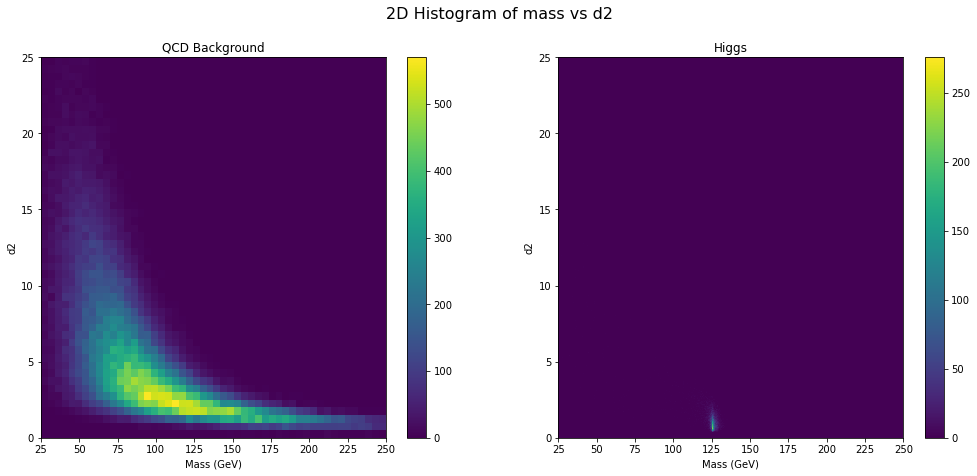

In [11]:
fig, axs = plt.subplots(1,2, figsize=(17,7))
_, _, _, img0 = axs[0].hist2d(qcd_data['mass'], qcd_data['d2'], bins=50, range=[[25,250],[0,25]])
_, _, _, img1 = axs[1].hist2d(higgs_data['mass'], higgs_data['d2'], bins=1000, range=[[25,250],[0,25]])
fig.suptitle("2D Histogram of mass vs d2", fontsize=16)
axs[0].set_title("QCD Background")
axs[1].set_title("Higgs")
for ax, img in zip(axs, [img0, img1]):
    fig.colorbar(img, ax=ax)
    ax.set_xlabel("Mass (GeV)")
    ax.set_ylabel("d2")


We can see immediately that these two features are not independent, but rather it appears, at least in the QCD data, that they are somewhat inversely correlated. The plots above both use the same axes to emphasize how much more tightly grouped the Higgs events are in feature space, but to make out any details of the Higgs distribution it is useful to zoom in somewhat.

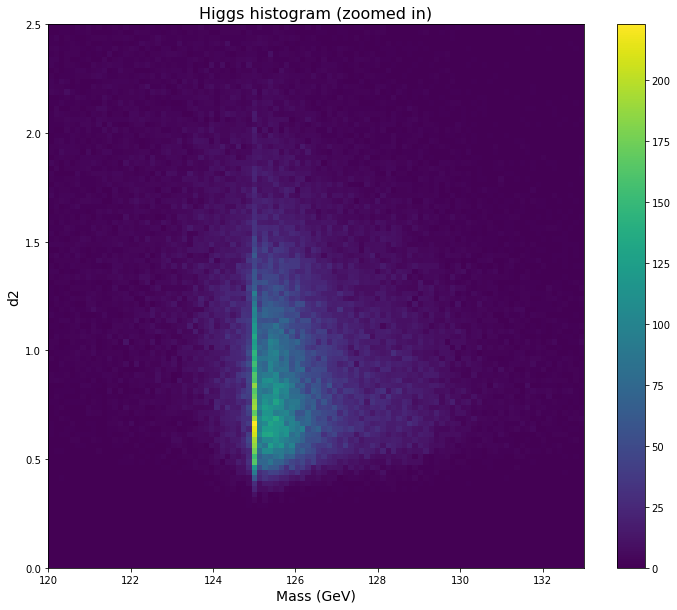

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
_, _, _, img = ax.hist2d(higgs_data['mass'], higgs_data['d2'], bins=100, range=[[120,133],[0,2.5]])
ax.set_title("Higgs histogram (zoomed in)", fontsize=16)
ax.set_xlabel("Mass (GeV)", fontsize=14)
ax.set_ylabel("d2", fontsize=14)
fig.colorbar(img, ax=ax);

From this we can see that the distribution has an apparently triangular shape, which motivates us to try selecting a region between two arbitrary lines in the `mass`-`d2` plane, giving us a triangular decision surface. To find the optimal such lines we follow the same procedure as before.

3.03 * d2 + 121.2 < mass < -8.35 * d2 + 136.9
Significance: 9.09 sigma
QCD Inclusion: 0.09% 	 Higgs Inclusion: 50.2%



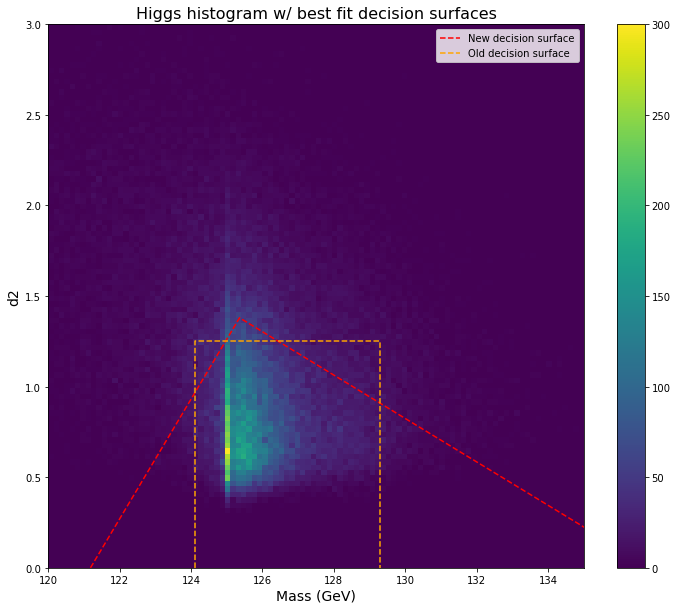

In [122]:
def triangle_cut(data, par):
    [m1,b1,m2,b2] = par
    mass = data['mass']
    d2 = data['d2']
    return (mass > m1 * d2 + b1) & (mass < m2 * d2 + b2)

tcut_par = optimize.differential_evolution(loss(triangle_cut, 50), [(0,30), (100,130), (-30,0), (120,150)]).x
[m1,b1,m2,b2] = tcut_par
print(f"{m1:.3} * d2 + {b1:.4} < mass < {m2:.3} * d2 + {b2:.4}")
print_performance(triangle_cut, tcut_par)

fig, ax = plt.subplots(1,1, figsize=(12,10))
_, _, _, img = ax.hist2d(higgs_data['mass'], higgs_data['d2'], bins=100, range=[[120,135],[0,3]])
int_mass =  (b1 - m1 / m2 * b2) / (1 - m1 / m2)
int_d2 = (int_mass - b2) / m2
ax.plot([b1, int_mass, b2], [0, int_d2, 0], color='red', linestyle='dashed', label="New decision surface")
ax.plot([124.1, 124.1, 129.3, 129.3], [0, 1.25, 1.25, 0], color='orange', linestyle='dashed', label="Old decision surface")
ax.set_title("Higgs histogram w/ best fit decision surfaces", fontsize=16)
ax.set_xlabel("Mass (GeV)", fontsize=14)
ax.set_ylabel("d2", fontsize=14)
ax.legend()
fig.colorbar(img, ax=ax);

We have plotted the decision surface found by the optimizer in red over top the 2D histogram. The independent 2-feature decision surface found in part 4 is also shown in orange for reference. The new filter has the same Higgs inclusion rate (50%) as the old one while managing a QCD inclusion rate that is apparently an order of magnitude lower, improving the expected significance from 8 sigma to 9 sigma.

# Lab 8

## Section 1

For everything that follows we will use the triangular cut found above. Below are histograms of the `mass` and `d2` distributions of the high luminosity dataset, before and after the cut, overlayed with the expected distributions from the tagged, simulated dataset. (The simulated data has been renormalized to match the total number of events, 40344, in the high luminosity experiment.)

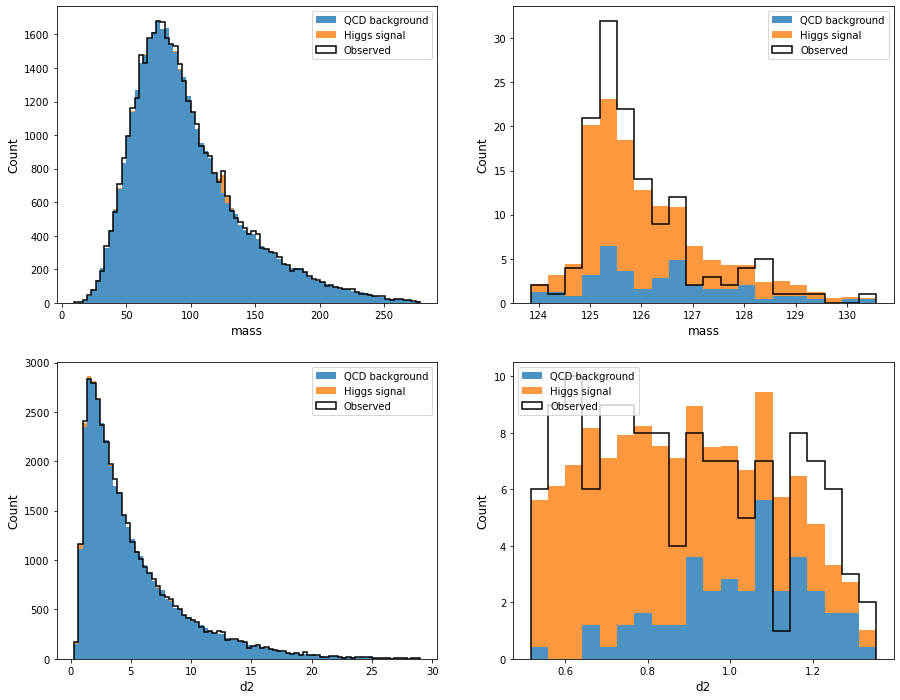

In [161]:
qcd_data_tcut = qcd_data[triangle_cut(qcd_data, tcut_par)]
higgs_data_tcut = higgs_data[triangle_cut(higgs_data, tcut_par)]
pex_high_tcut = pex_high[triangle_cut(pex_high, tcut_par)]

higgs_weight_pexhigh = 40344 * (100 / 20100) / 100000
qcd_weight_pexhigh = 40344 * (20000 / 20100) / 100000

fig, ax_grid = plt.subplots(2,2, figsize=(15,12))

for axs, feature in zip(ax_grid, ['mass', 'd2']):
    ran = (qcd_data[feature].min(), np.percentile(qcd_data[feature], 99.9))
    axs[0].hist(
        [qcd_data[feature], higgs_data[feature]],
        weights=[np.repeat(qcd_weight_pexhigh, 100000), np.repeat(higgs_weight_pexhigh, 100000)],
        label=["QCD background", "Higgs signal"],
        bins=80, 
        range=ran,
        stacked=True,
        alpha=0.8
    )
    axs[0].hist(
        pex_high[feature],
        label="Observed",
        bins=80,
        range=ran,
        histtype='step',
        linewidth=1.5,
        color='black'
    )
    
    cut_ran = (qcd_data_tcut[feature].min(), qcd_data_tcut[feature].max())
    axs[1].hist(
        [qcd_data_tcut[feature], higgs_data_tcut[feature]],
        weights=[np.repeat(qcd_weight_pexhigh, qcd_data_tcut.shape[0]), np.repeat(higgs_weight_pexhigh, higgs_data_tcut.shape[0])],
        label=["QCD background", "Higgs signal"],
        bins=20, 
        range=cut_ran,
        stacked=True,
        alpha=0.8
    )
    axs[1].hist(
        pex_high_tcut[feature],
        label="Observed",
        bins=20,
        range=cut_ran,
        histtype='step',
        linewidth=1.5,
        color='black'
    )
    
    for ax in axs:
        ax.legend()
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel("Count", fontsize=12)

In [133]:
Nqcd = qcd_data_tcut.shape[0] * qcd_weight_pexhigh
Nobs = pex_high_tcut.shape[0]
sigma = stats.norm.isf(stats.poisson.sf(Nobs, mu=Nqcd))
print(f"Expected background: {Nqcd:.3}\nObserved: {Nobs}\nSignificance: {sigma:.3} sigma")

Expected background: 36.1
Observed: 139
Significance: 13.1 sigma


Based on the simulated data, in the Higgs-less background theory, we would expect on average to see 36.1 events in the cut region, but we actually found 139. This excess has a significance of 13.1 sigma, which is even higher than the expected significance of 9 sigma calculated earlier. This isn't surprising, since the high lumonisity experiment contains more than double the number of events of the simulated experiment we've been assuming until now.

## Section 2

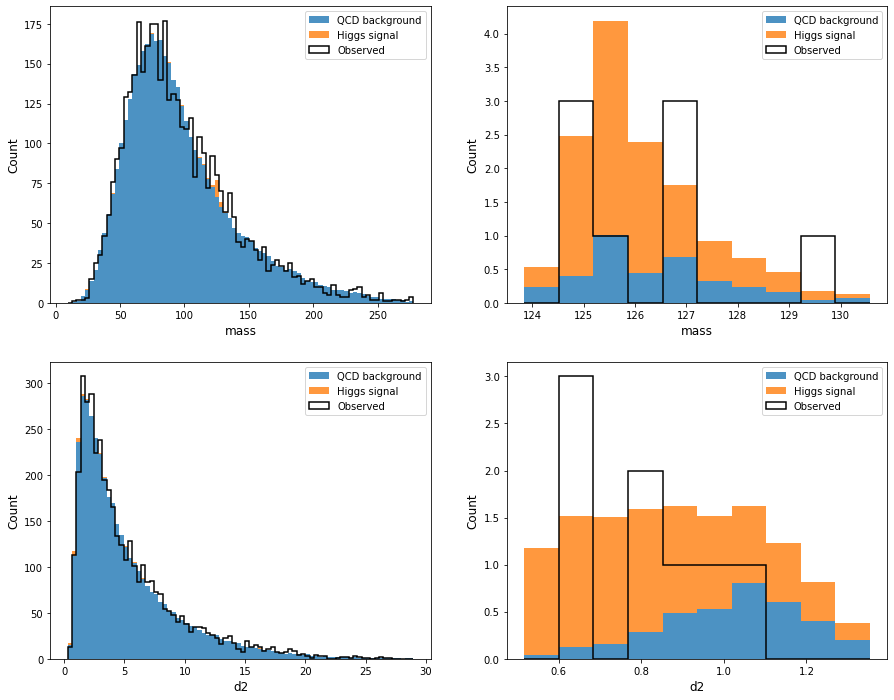

In [158]:
pex_low_tcut = pex_low[triangle_cut(pex_low, tcut_par)]

higgs_weight_pexlow = 4060 * (100/20100) / 100000
qcd_weight_pexlow = 4060 * (20000/20100) / 100000

fig, ax_grid = plt.subplots(2,2, figsize=(15,12))

for axs, feature in zip(ax_grid, ['mass', 'd2']):
    ran = (qcd_data[feature].min(), np.percentile(qcd_data[feature], 99.9))
    axs[0].hist(
        [qcd_data[feature], higgs_data[feature]],
        weights=[np.repeat(qcd_weight_pexlow, 100000), np.repeat(higgs_weight_pexlow, 100000)],
        label=["QCD background", "Higgs signal"],
        bins=80,
        range=ran,
        stacked=True,
        alpha=0.8
    )
    axs[0].hist(
        pex_low[feature],
        label="Observed",
        bins=80,
        range=ran,
        histtype='step',
        linewidth=1.5,
        color='black'
    )
    
    cut_ran = (qcd_data_tcut[feature].min(), qcd_data_tcut[feature].max())
    axs[1].hist(
        [qcd_data_tcut[feature], higgs_data_tcut[feature]],
        weights=[np.repeat(qcd_weight_pexlow, qcd_data_tcut.shape[0]), np.repeat(higgs_weight_pexlow, higgs_data_tcut.shape[0])],
        label=["QCD background", "Higgs signal"],
        bins=10,
        range=cut_ran,
        stacked=True,
        alpha=0.8
    )
    axs[1].hist(
        pex_low_tcut[feature],
        label="Observed",
        bins=10,
        range=cut_ran,
        histtype='step',
        linewidth=1.5,
        color='black'
    )
    
    for ax in axs:
        ax.legend()
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel("Count", fontsize=12)

In [132]:
Nqcd = qcd_data_tcut.shape[0] * qcd_weight_pexlow
Nobs = pex_low_tcut.shape[0]
sigma = stats.norm.isf(stats.poisson.sf(Nobs, mu=Nqcd))
print(f"Expected background: {Nqcd:.3}\nObserved: {Nobs}\nSignificance: {sigma:.3} sigma")

Expected background: 3.64
Observed: 8
Significance: 2.25 sigma


This time, we observe 8 events in the cut region, compared to the expected background of 3.64, which is an excess of significance of 2.25 sigma. Similar to before, we would expect this significance to be smaller since the dataset is much smaller.

## Section 3

Now, we want to calculate the 95% confidence upper limit of the signal strength in each of the three pseudoexperiments (simulated, high luminosity, and low luminosity). In this case, we take the total number of events observed to be fixed and given, and interpret "signal strength" as the mean number of Higgs events one would expect to find in that many total events. We also assume that the true number of higgs events is determined by a Poisson distribution (with mean determined by the signal strength), and that the QCD and Higgs inclusion rates we calculated before for our cuts are exact. That is, the cut will always include exactly 50.1% of all Higgs jets present in the experiment, and so on.

With these assumptions, then given an observation, i.e. the total number of events _actually_ included in the cut, we can calculate the distribution of signal strengths which could have produced that result and then take the 95th percentile of that distribution.

In [194]:
qcd_incl = qcd_data_tcut.shape[0] / 100000
higgs_incl = higgs_data_tcut.shape[0] / 100000

def signal_upper_limit(total, observed, max_signal):
    signal = np.linspace(0, max_signal, 10000000)
    total_higgs = stats.poisson.rvs(mu=signal) # number of higgs in the experiment
    caught_higgs = higgs_incl * total_higgs # number of higgs included in the cut
    caught_qcd = qcd_incl * (total - total_higgs) # number of qcd events included in the cut
    caught = caught_higgs + caught_qcd # number of events in the cut
    signal_dist = signal[np.abs(caught - observed) < 1]
    return np.percentile(signal_dist, 95)

expected_observed = qcd_data_tcut.shape[0] * qcd_weight + higgs_data_tcut.shape[0] * higgs_weight
expected_upper = signal_upper_limit(20100, expected_observed, 200)

pex_high_upper = signal_upper_limit(40344, pex_high_tcut.shape[0], 400)

pex_low_upper = signal_upper_limit(4060, pex_low_tcut.shape[0], 50)

pd.DataFrame(
    [[expected_upper, expected_upper / 2000],
     [pex_high_upper, pex_high_upper / 4034.4],
     [pex_low_upper, pex_low_upper / 40.6]],
    index=["Expected", "High luminosity", "Low luminosity"],
    columns=["Total yield", "Percent yield"]
)

,Total yield,Percent yield
Expected,118.084616,0.059042
High luminosity,229.670183,0.056928
Low luminosity,15.443318,0.380377


This calculation shows that the simulated experiment set an upper limit mean Higgs yield of 118.1 events, corresponding to a percent yield of 0.059%, while the high luminosity experiment hset an upper limit of 229.5 events (0.057%), and the low luminosity experiment set an upper limit of 15.4 events (0.38%). Note that the simulated and high-luminosity experiments agree well, while the limit from the low-luminosity experiment is an order of magnitude larger. This is just a result of the fact that the experiment contained far fewer events, so the uncertainies are greater and thus any upper limit will be correspondingly weaker i.e. larger.